In [ ]:
#| default_exp 05-metadata-augmented-input-and-trie-for-distilbert

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import os, pandas as pd, warnings, torch, pickle
from tqdm.auto import tqdm
from scipy import stats

from xcai.basics import *
from xcai.models.MMM00X import DBT007, DBT008
from xcai.transform import AugmentMetaInputIdsTfm

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
#| export
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
dump_dir = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/'

In [ ]:
block = XCBlock.from_cfg('data_meta', valid_pct=0.001, tokenizer='distilbert-base-uncased')

/home/scai/phd/aiz218323/.local/lib/python3.9/site-packages/xclib-0.97-py3.9-linux-x86_64.egg/xclib/data/data_utils.py:263: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")
/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
block = AugmentMetaInputIdsTfm.apply(block, meta='hlk_meta', max_len=512, exclude_sep=True)

In [ ]:
block.test.dset.data.data_info['input_ids'] = block.test.dset.data.data_info['input_ids_aug_hlk']
block.test.dset.data.data_info['attention_mask'] = block.test.dset.data.data_info['attention_mask_aug_hlk']

In [ ]:
test_dset = block.test.dset.sample(n=2000, seed=50)

In [ ]:
block

In [ ]:
with open(f'{dump_dir}/data/block.pkl', 'wb') as f: pickle.dump((block, test_dset), f)

In [ ]:
#| export
with open(f'{dump_dir}/data/block.pkl', 'rb') as f: block, test_dset = pickle.load(f)

# Generation

In [ ]:
#| export
mname = f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000'
model = DBT007.from_pretrained(mname, tn_targ=10_000, ig_tok=0)

Some weights of DBT007 were not initialized from the model checkpoint at /scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert//distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000 and are newly initialized: ['loss_fn.o']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#| export
args = XCLearningArguments(
    output_dir=f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K',
    generation_length_penalty=1.5,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
#| export
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the envi

## `trie`

In [ ]:
#| export
trie = XCTrie.from_block(block)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [ ]:
#| export
learn.tbs.trie = trie

In [ ]:
#| export
learn.tbs.n_bm = learn.args.generation_num_beams = 10
# learn.tbs.n_bm = learn.args.generation_num_beams = 200

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,27.35,15.9,11.64,6.865,27.35,25.1513,25.4696,26.4075,16.4449,15.8475,16.6908,18.0965,16.4449,17.0123,17.8246,18.9196,19.8771,22.6592,28.849,29.0056,29.0056,29.0056,7.0555,226.4585,8.832,0.278


In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

torch.save(o, f'{mname}/predictions/test_lbl_n-bm-10_n-smp-2000_seed-50.pth')

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,27.35,15.9,11.64,6.865,27.35,25.1513,25.4696,26.4075,16.4527,15.8567,16.7021,18.1073,16.4527,17.0189,17.8322,18.9273,19.8771,22.6592,28.849,29.0056,29.0056,29.0056,7.0555,325.2337,6.149,0.194


In [ ]:
#| export
o = learn.predict(test_dset)
display_metric(o.metrics)

torch.save(o, f'{mname}/predictions/test_lbl_n-bm-200_n-smp-2000_seed-50.pth')

metrics with beam size 200

In [ ]:
metric = {'test_loss': 7.055476665496826, 'test_P@1': 0.282, 'test_P@10': 0.07699999999999917, 'test_P@3': 0.1689999999999995, 
          'test_P@5': 0.12469999999999892, 'test_N@1': 0.28200000524520874, 'test_N@10': 0.284577339887619, 'test_N@3': 0.26439911127090454, 
          'test_N@5': 0.26965513825416565, 'test_PSP@1': 0.16898056897652436, 'test_PSP@10': 0.20569674669082327, 
          'test_PSP@3': 0.16874163851237, 'test_PSP@5': 0.17929264835131836, 'test_PSN@1': 0.16898056864738464, 
          'test_PSN@10': 0.20554141700267792, 'test_PSN@3': 0.17881405353546143, 'test_PSN@5': 0.1890701949596405, 
          'test_R@2': 0.20791401888960684, 'test_R@3': 0.2390257254055973, 'test_R@100': 0.45159772836170625, 
          'test_R@200': 0.4830375611805152, 'test_R@10': 0.32105064905857505, 'test_R@50': 0.41466900763020315, 'test_runtime': 4093.1453, 
          'test_samples_per_second': 0.489, 'test_steps_per_second': 0.015}

In [ ]:
display_metric(metric)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,28.2,16.9,12.47,7.7,28.2,26.4399,26.9655,28.4577,16.8981,16.8742,17.9293,20.5697,16.8981,17.8814,18.907,20.5541,20.7914,23.9026,32.1051,41.4669,45.1598,48.3038,7.0555,4093.1453,0.489,0.015


## `meta-augmented trie`

In [ ]:
a_trie = XCTrie.from_block(block, meta=['hlk'])

  0%|          | 0/312330 [00:00<?, ?it/s]

  0%|          | 0/2458399 [00:00<?, ?it/s]

In [ ]:
learn.tbs.trie = a_trie

In [ ]:
learn.tbs.n_bm = learn.args.generation_num_beams = 20

In [ ]:
o = learn.predict(block.test.dset)
print(o.metrics)

torch.save(o, f'{mname}/predictions/test_lbl_atrie-hlk.pth')

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

torch.save(o, f'{mname}/predictions/test_lbl_atrie-hlk_n-smp-2000_seed-50.pth')

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,14.1,7.95,5.78,3.435,14.1,13.1937,13.4809,14.0918,8.5007,8.0784,8.5338,9.2986,8.5007,8.7138,9.2098,9.8224,10.4457,12.2458,16.0001,23.2354,27.7496,32.3926,7.0555,556.0075,3.597,0.113


In [ ]:
o

XCPredictionOutput(pred_idx=tensor([229942,  45914,  94437,  ..., 201199, 264804, 196870]), pred_ptr=tensor([ 80, 182, 425,  ..., 124,  64,  91]), pred_score=tensor([-1.0248, -0.8172, -0.9253,  ..., -0.2052, -0.3543, -0.3543]), metrics={'test_loss': 7.055476665496826, 'test_P@1': 0.141, 'test_P@10': 0.03435000000000015, 'test_P@3': 0.07950000000000002, 'test_P@5': 0.0578000000000004, 'test_N@1': 0.14100000262260437, 'test_N@10': 0.14091801643371582, 'test_N@3': 0.13193659484386444, 'test_N@5': 0.13480877876281738, 'test_PSP@1': 0.08500727489465619, 'test_PSP@10': 0.09298637620337616, 'test_PSP@3': 0.08078358832508743, 'test_PSP@5': 0.08533770403099876, 'test_PSN@1': 0.08500727266073227, 'test_PSN@10': 0.09822390973567963, 'test_PSN@3': 0.08713830262422562, 'test_PSN@5': 0.09209804981946945, 'test_R@2': 0.1044574460914902, 'test_R@3': 0.1224579345377433, 'test_R@100': 0.2774955116501733, 'test_R@200': 0.3239256327250691, 'test_R@10': 0.16000144774838873, 'test_R@50': 0.23235361882078026

### __Shortlist & Total recall__

All the numbers reported below are on a sample of 2000 points.

In [ ]:
s = get_tensor_statistics(o.pred_ptr);s

,mean,std,25,50,75
0,883.69751,2922.354004,92.75,186.0,447.25


In [ ]:
r, rm = total_recall(o.pred_idx, o.pred_ptr, test_dset.data.data_lbl, test_dset.data.data_lbl_filterer) 
print(f'Total recall : {r*100:.3f}')

Total recall : 43.611


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
r = get_tensor_statistics(torch.tensor(rm.sum(axis=1)).flatten()*rm.shape[0]*100); r

,mean,std,25,50,75
0,43.611488,42.201412,0.0,33.333332,100.0


In [ ]:
data_rec = torch.tensor(rm.sum(axis=1)).flatten()

<matplotlib.collections.PathCollection>

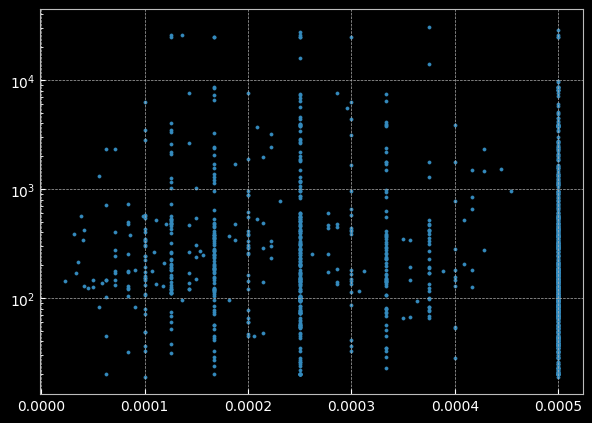

In [ ]:
import matplotlib.pyplot as plt

set_plot_defaults()
plt.figure(figsize=(7,5))
plt.yscale('log')
idx = torch.where(data_rec > 0)[0]
plt.scatter(data_rec[idx], o.pred_ptr[idx], s=5)

In [ ]:
stats.pearsonr(data_rec, o.pred_ptr), stats.spearmanr(data_rec, o.pred_ptr)

(PearsonRResult(statistic=0.037018564878015636, pvalue=0.09791378546071804),
 SignificanceResult(statistic=0.0029317360208657556, pvalue=0.8957519439209245))

# Representation

In [ ]:
args = XCLearningArguments(
    output_dir=f'{dump_dir}/ngame_v-3-100_(mapped)LF-WikiSeeAlsoTitles-320K/',
    index_efs=200,
    representation_num_beams=200,
    generation_length_penalty=1.5,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()
model = DBT008.from_pretrained('sentence-transformers/msmarco-distilbert-base-v4', bsz=bsz, tn_targ=10_000, ig_tok=0)

Some weights of DBT008 were not initialized from the model checkpoint at sentence-transformers/msmarco-distilbert-base-v4 and are newly initialized: ['loss_fn.u', 'loss_fn.v']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from collections import OrderedDict

mname = f'{args.output_dir}/model_network.pkl'
m_state_dict, msd = OrderedDict(), torch.load(mname)
for k in msd:
    o = k.split('.')
    if o[0] == 'encoder': m_state_dict['distilbert.'+'.'.join(o[5:])] = msd[k]
model.load_state_dict(m_state_dict, strict=False)


_IncompatibleKeys(missing_keys=['loss_fn.u', 'loss_fn.v'], unexpected_keys=[])

In [ ]:
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


ngame metrics with beam size 200

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

  0%|          | 0/9761 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,35.5,22.9167,17.32,10.975,35.5,34.7277,35.8913,38.2541,24.7755,26.625,29.1801,34.1228,24.7755,27.3746,29.4248,32.1409,27.4353,31.6029,43.9882,57.4864,62.7014,67.7988,0.3482,21.2901,93.94,2.959


In [ ]:
o = learn.predict(block.test.dset)
display_metric(o.metrics)

  0%|          | 0/2441 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
pred_dir = f'{args.output_dir}/predictions/'
os.makedirs(pred_dir, exist_ok=True)
torch.save(o, f'{pred_dir}/test_lbl.pth')

## Reranking

In [ ]:
import torch.nn.functional as F

In [ ]:
data_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset)), dim=1)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
lbl_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset.lbl_dset)), dim=1)

  0%|          | 0/9761 [00:00<?, ?it/s]

In [ ]:
pred = torch.load(f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/\
predictions/test_lbl_atrie-hlk_n-smp-2000_seed-50.pth')

In [ ]:
from tqdm.auto import tqdm
sc,p = [],0
for q,d in tqdm(zip(pred.pred_ptr.cumsum(0),data_repr), total=data_repr.shape[0]):
    sc.append(d@lbl_repr[pred.pred_idx[p:q]].T);p=q
sc = torch.cat(sc)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
o = {
    'pred_idx': pred.pred_idx,
    'pred_ptr': pred.pred_ptr,
    'pred_score': pred.pred_score,
}
o['targ_idx'] = torch.tensor(test_dset.data.data_lbl.indices, dtype=torch.long)
o['targ_ptr'] = torch.tensor([o.getnnz() for o in test_dset.data.data_lbl])

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,14.1,7.95,5.78,3.435,14.1,13.19366,13.480878,14.091802,8.500727,8.078359,8.53377,9.298638,8.500728,8.71383,9.209805,9.822391,10.445745,12.245793,16.000145,23.235362,27.749551,32.392563


In [ ]:
o['pred_score'] = sc

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,27.05,18.283333,13.78,8.505,27.050001,27.158207,28.092009,29.566076,16.910834,19.011092,20.906068,23.913551,16.910835,19.219286,20.758394,22.45076,20.552134,25.236278,34.40866,40.847185,41.775963,42.372265
